## Principal Component Analysis (PCA) for Dimensionality Reduction

### Imports and Setup

In [70]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [71]:
# Load data from dataset_generators/datasets
final_df_with_lags = pd.read_csv('../dataset_generators/datasets/final_1_lag_ffa_dataset.csv')

### XGBoost w/ PCA Hyperparameter Tuning

In [ ]:
# Function to perform hyperparameter tuning on XGBoost model with PCA using GridSearchCV
def hyperparameter_tuning(df):
    pipeline = Pipeline([
        ('pca', PCA(n_components=0.95)),  # Retain 95% variance
        ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
    
    # use train_test_split to create a validation set
    train_df, _ = train_test_split(df, test_size=0.2, random_state=42)

    features = train_df.iloc[:, 11:].drop(columns=['fantasy_points'])
    target = train_df['fantasy_points']

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    target = scaler.fit_transform(target.values.reshape(-1, 1)).ravel()
    
    # Refined parameter grid based on visualizations from later cells
    param_grid = {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.01, 0.02],  # From learning rate plot
        'regressor__max_depth': [3, 7],  # From max_depth plot
        'regressor__subsample': [0.7, 0.9],
        'regressor__colsample_bytree': [0.7, 0.9],
        'regressor__min_child_weight': [1, 3],
        'regressor__reg_alpha': [0.01, 0.1],
        'regressor__reg_lambda': [1, 2]
    }
    
    scoring = ['neg_root_mean_squared_error', 'r2', 'neg_mean_absolute_error']

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=scoring,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    grid_search.fit(features, target)
    print("Best parameters found: ", grid_search.best_params_)
    
    rmse = np.sqrt(-grid_search.best_score_)
    r2 = r2_score(target, grid_search.predict(features))
    mae = mean_absolute_error(target, grid_search.predict(features))
    pca = grid_search.best_estimator_.named_steps['pca']
    print(f"Explained variance ratio with {pca.n_components_} components: {np.sum(pca.explained_variance_ratio_):.4f}")
    print("Best RMSE from GridSearchCV: ", rmse)
    print("R² on training data with best estimator: ", r2)
    print("MAE on training data with best estimator: ", mae)
    return grid_search.best_estimator_

# Execute hyperparameter tuning
best_estimator = hyperparameter_tuning(final_df_with_lags)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters found:  {'regressor__colsample_bytree': 0.9, 'regressor__learning_rate': 0.02, 'regressor__max_depth': 7, 'regressor__min_child_weight': 3, 'regressor__n_estimators': 200, 'regressor__reg_alpha': 0.1, 'regressor__reg_lambda': 2, 'regressor__subsample': 0.7}
Explained variance ratio with 25 components: 0.9515
Best RMSE from GridSearchCV:  0.7742932572653619
R² on training data with best estimator:  0.49977643572692576
MAE on training data with best estimator:  0.5159824574675206


In [95]:
best_estimator

# Extract XGBoost model from best_estimator pipeline
xgb_pca_model = best_estimator.named_steps['regressor']
print("XGBoost model parameters:")
print(xgb_pca_model.get_params())

pca = best_estimator.named_steps['pca']
print("PCA model parameters:")
print(pca.get_params())

XGBoost model parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 2, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
PCA model parameters:
{'copy': True, 'iterated_power': 'auto', 

In [ ]:
import pickle

# Save best_xgb_pca_model using pickle
with open('models/best_xgb_pca_model.pkl', 'wb') as f:
    pickle.dump(xgb_pca_model, f)
    
# Save best_pca_model using pickle
with open('models/pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)

### Load 5-Fold Cross-Validation Non-Normalized Data

In [74]:
# Function to load the KFold PCA data
def load_kfold_pca_data(fold):
    train = pd.read_csv(f'../dataset_generators/datasets/{fold}_train_pca.csv')
    test = pd.read_csv(f'../dataset_generators/datasets/{fold}_test_pca.csv')
    return train, test

### PCA Application

In [ ]:
rmse_list = []
r2_list = []
mae_list = []

# Function to perform 5-fold cross-validation and train XGBoost model with PCA
def cross_validate_model_with_pca():
    for fold in range(5):
        train, test = load_kfold_pca_data(fold)
        X_train_pca = train.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_train = train['fantasy_points']
        X_test_pca = test.iloc[:, 12:].drop(columns=['fantasy_points'])
        y_test = test['fantasy_points']

        # Train XGBoost model with PCA transformed data
        model = xgb_pca_model
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        rmse = root_mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print("Predictions:", y_pred)
        print("Root Mean Squared Error:", rmse)
        print("R^2 Score:", r2)
        print("Mean Absolute Error:", mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
        mae_list.append(mae)
        
        # Save to json file
        fold_results = {
            'fold': fold,
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'predictions': y_pred.tolist(),
            'y_test': y_test.tolist()
        }
        with open(f'fold_{fold}_results.json', 'w') as f:
            import json
            json.dump(fold_results, f, indent=4)
            
    print("\n")
    # Calculate mean of RMSE and R^2 Score across all folds
    mean_rmse = sum(rmse_list) / len(rmse_list) if rmse_list else 0
    mean_r2 = sum(r2_list) / len(r2_list) if r2_list else 0
    mean_mae = sum(mae_list) / len(mae_list) if mae_list else 0
    print("Mean RMSE across all folds:", mean_rmse)
    print("Mean R^2 Score across all folds:", mean_r2)
    print("Mean MAE across all folds:", mean_mae)

    return model, X_test_pca, y_test, X_train_pca, y_train

model, X_test_pca, y_test, X_train_pca, y_train = cross_validate_model_with_pca()

Predictions: [16.949331  13.914644  19.368416  ...  6.2974586  3.6161005  5.0099936]
Root Mean Squared Error: 5.408380674595216
R^2 Score: 0.4003677646752354
Mean Absolute Error: 3.9010589839877587
Predictions: [ 4.7126565  2.4719136 18.618366  ...  1.4654286  3.6104343  3.8261673]
Root Mean Squared Error: 5.439272484679124
R^2 Score: 0.40635604866192565
Mean Absolute Error: 3.924872000571331
Predictions: [ 8.904135  14.157425  19.700132  ...  2.753544   5.7142096  5.3995566]
Root Mean Squared Error: 5.474737581527381
R^2 Score: 0.4003032852914563
Mean Absolute Error: 3.9289324782499624
Predictions: [14.913912  19.671495  17.875235  ...  4.180421   3.3372028  5.0670004]
Root Mean Squared Error: 5.35115103323175
R^2 Score: 0.4000839187798404
Mean Absolute Error: 3.8585837526948645
Predictions: [ 7.4210916 14.434242  14.421357  ...  5.582048   6.756597   7.469759 ]
Root Mean Squared Error: 5.303568029725255
R^2 Score: 0.40474844400891463
Mean Absolute Error: 3.8073558602438267


Mean RMS

In [76]:
# Function to create train final dataframe with PCA features and first 11 columns
# def create_train_final_df_with_pca(X_train_pca, y_train, final_df_with_lags):
#     # Create dataframe with first 11 columns from original data
#     indices = y_train.index
#     first_11_cols = final_df_with_lags.iloc[indices, :11]
    
#     # Create dataframe with PCA features
#     pca_cols = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
#     pca_df = pd.DataFrame(X_train_pca, columns=pca_cols, index=indices)

#     # Combine first 11 columns with PCA features and fantasy points
#     final_df_with_lags_pca = pd.concat([first_11_cols, pca_df], axis=1)
#     final_df_with_lags_pca['fantasy_points'] = y_train
    
#     return final_df_with_lags_pca

# final_df_with_lags_pca_train = create_train_final_df_with_pca(X_train_pca, y_train, final_df_with_lags)
# final_df_with_lags_pca_train
# csv_path = '../dataset_generators/datasets/final_1_lag_ffa_dataset_pca_train.csv'
# final_df_with_lags_pca_train.to_csv(csv_path, index=False)

In [77]:
# Function to create test final dataframe with PCA features and first 11 columns
# def create_test_final_df_with_pca(X_test_pca, y_test, final_df_with_lags):
#     # Create dataframe with first 11 columns from original data
#     indices = y_test.index
#     first_11_cols = final_df_with_lags.iloc[indices, :11]
    
#     # Create dataframe with PCA features
#     pca_cols = [f'PC{i+1}' for i in range(X_test_pca.shape[1])]
#     pca_df = pd.DataFrame(X_test_pca, columns=pca_cols, index=indices)
    
#     # Combine first 11 columns with PCA features and fantasy points
#     final_df_with_lags_pca = pd.concat([first_11_cols, pca_df], axis=1)
#     final_df_with_lags_pca['fantasy_points'] = y_test
    
#     return final_df_with_lags_pca

# final_df_with_lags_pca_test = create_test_final_df_with_pca(X_test_pca, y_test, final_df_with_lags)
# final_df_with_lags_pca_test
# csv_path = '../dataset_generators/datasets/final_1_lag_ffa_dataset_pca_test.csv'
# final_df_with_lags_pca_test.to_csv(csv_path, index=False)

In [78]:
# Function to load PCA pkl models
# import pickle

# def load_kfold_pca_model(fold):
#     with open(f'../dataset_generators/datasets/{fold}_pca.pkl', 'rb') as f:
#         pca_model = pickle.load(f)
#     return pca_model

# # Get PCA model from the third fold
# pca = load_kfold_pca_model(3)

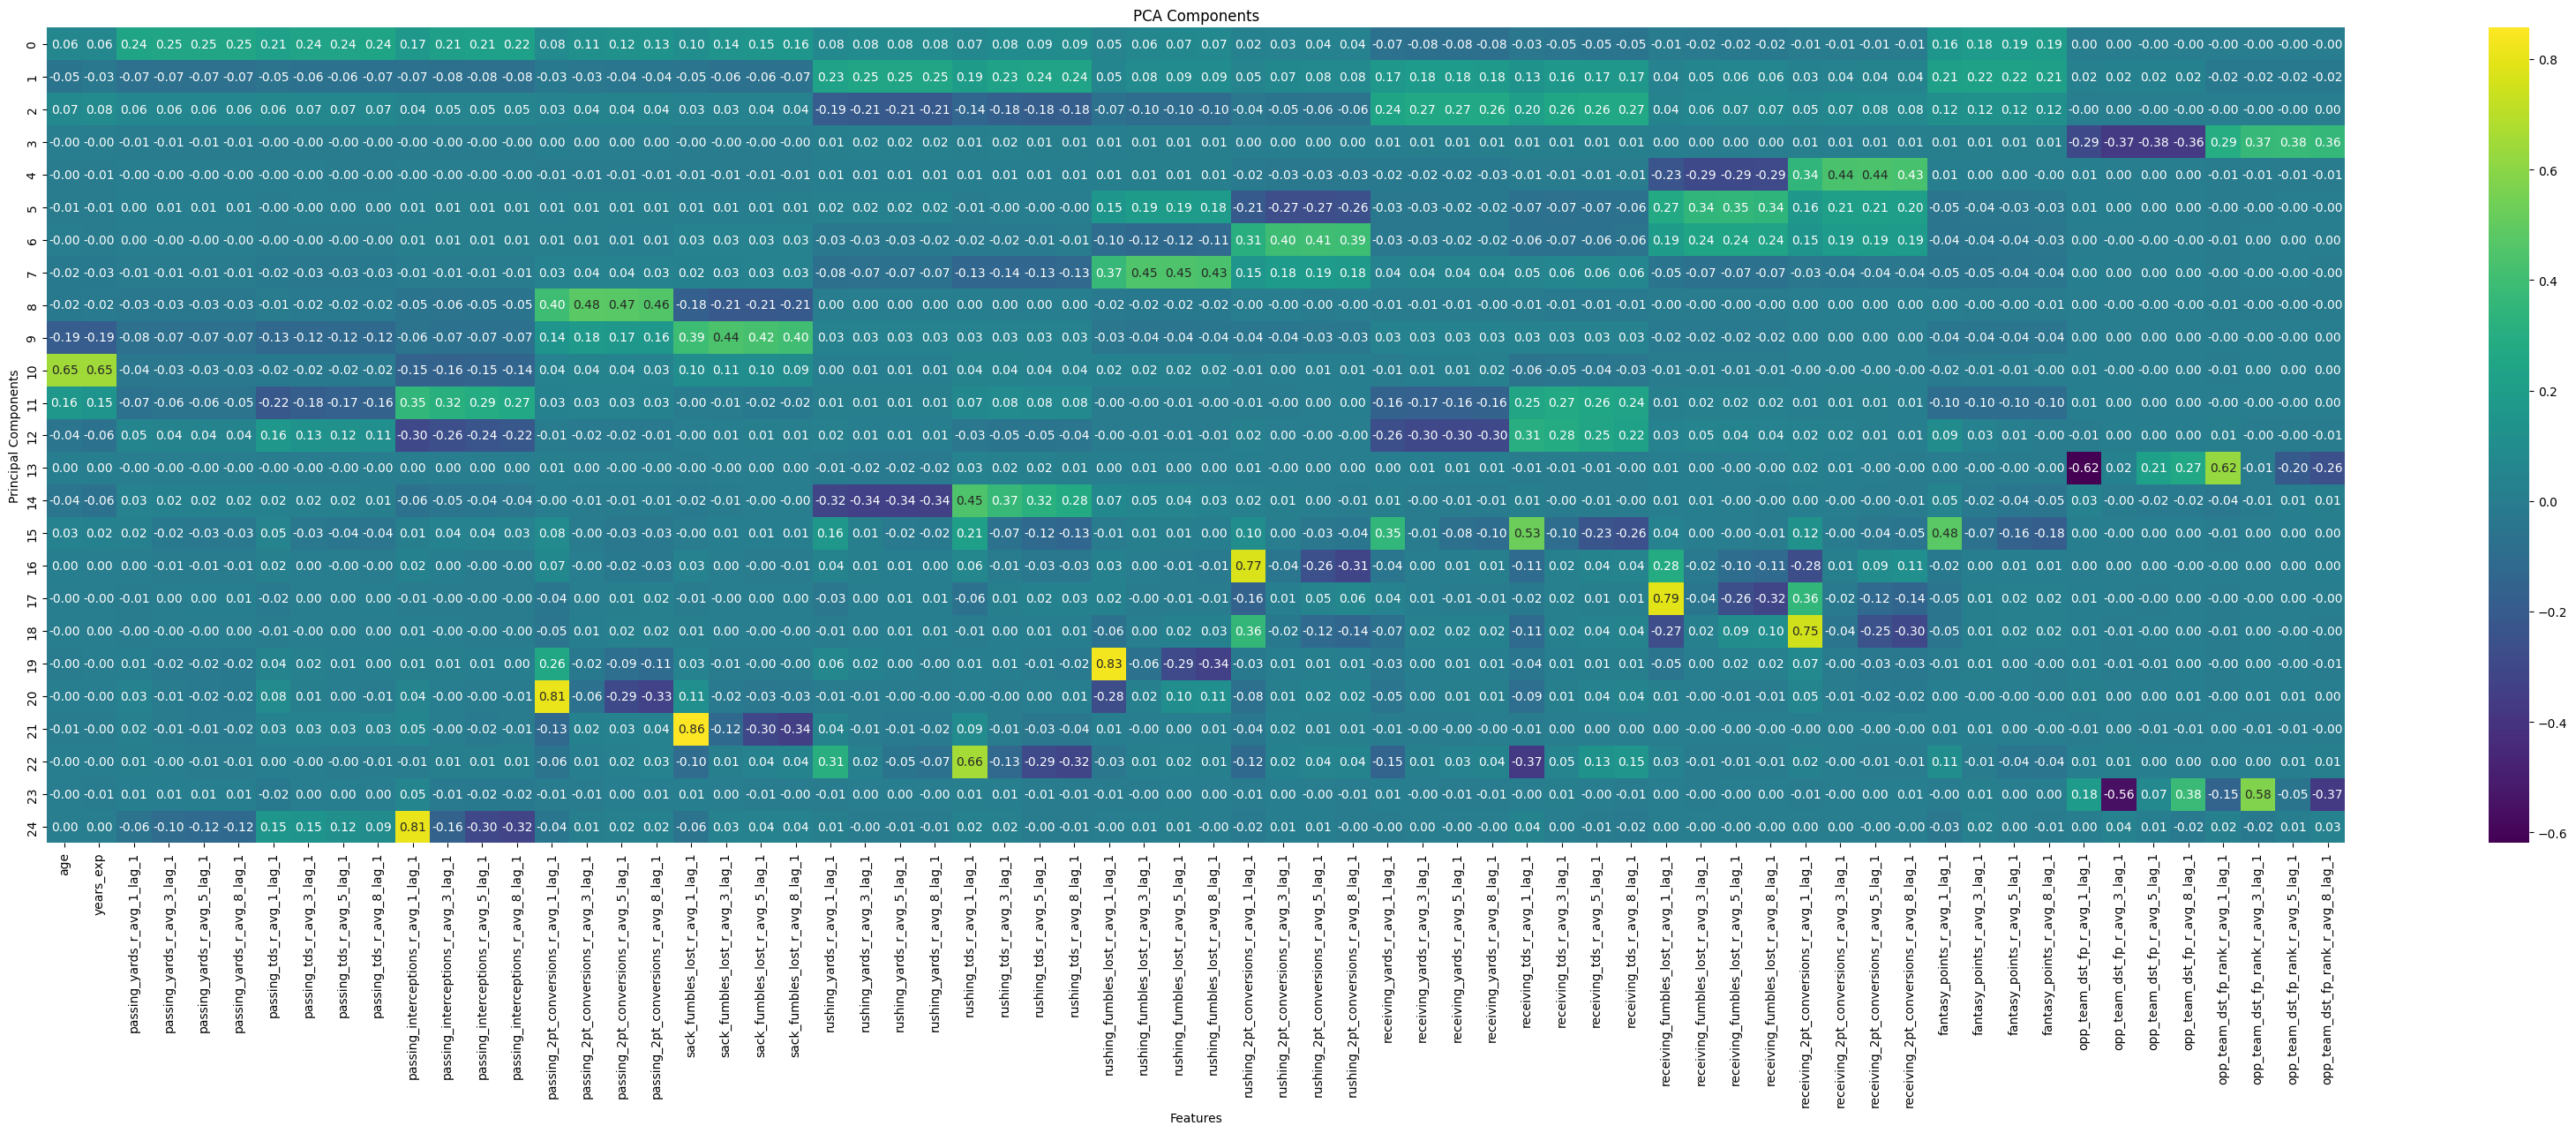

In [79]:
# Function to plot PCA components
def plot_pca_components(pca, feature_names):
    # Create a DataFrame for the PCA components
    pca_components = pd.DataFrame(pca.components_, columns=feature_names)
    
    # Plot the PCA components
    plt.figure(figsize=(42, 12))
    sns.heatmap(pca_components, cmap='viridis', annot=True, fmt=".2f")
    plt.title("PCA Components")
    plt.xlabel("Features")
    plt.ylabel("Principal Components")
    plt.show()
    
plot_pca_components(pca, final_df_with_lags.columns[11:].drop('fantasy_points'))

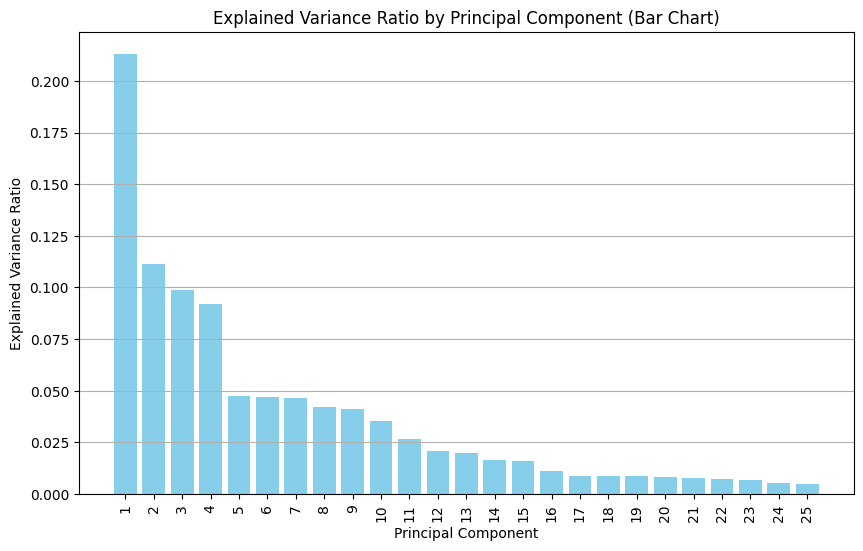

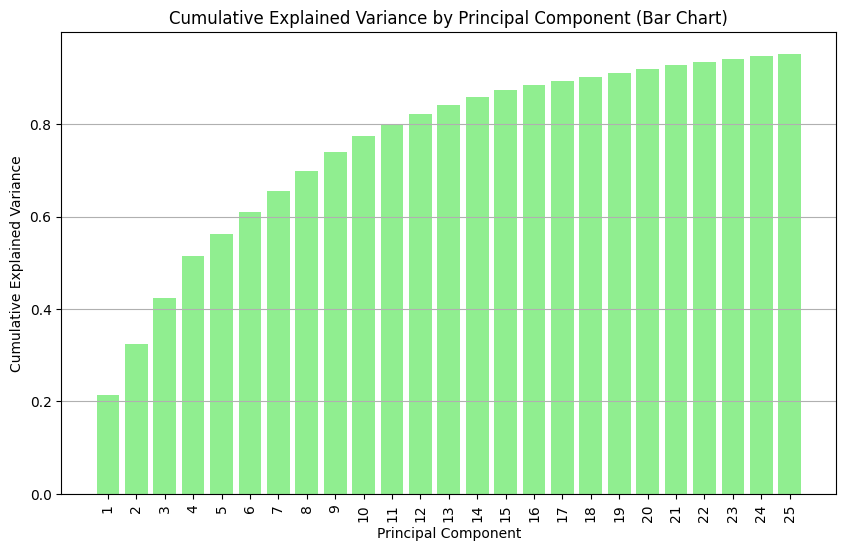

In [80]:
# function plot PcA explained variance
def plot_explained_variance(pca):
    # Bar chart for explained variance ratio of each principal component
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, color='skyblue')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Component (Bar Chart)')
    plt.xticks(np.arange(1, len(pca.explained_variance_ratio_)+1), rotation=90)
    plt.grid(axis='y')
    plt.show()

    # Bar chart for cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10,6))
    plt.bar(np.arange(1, len(cumulative_variance)+1), cumulative_variance, color='lightgreen')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by Principal Component (Bar Chart)')
    plt.xticks(np.arange(1, len(cumulative_variance)+1), rotation=90)
    plt.grid(axis='y')
    plt.show()
    
plot_explained_variance(pca)

In [81]:
# Function to extract PCA features
def extract_pca_features(pca):
    # export pca data to csv
    # pca_df = pd.DataFrame(pca.components_)
    # pca_df.to_csv('pca_components.csv', index=False)
    
    # Use the feature names from the original DataFrame columns
    feature_names = [col for col in final_df_with_lags.columns[11:] if col != 'fantasy_points']
    pca_columns = [f'PC{i+1}' for i in range(pca.n_components_)]
    pca_features = pd.DataFrame(pca.components_, columns=feature_names, index=pca_columns)
    return pca_features

pca_features = extract_pca_features(pca)

In [82]:
pca_features

,age,years_exp,passing_yards_r_avg_1_lag_1,passing_yards_r_avg_3_lag_1,passing_yards_r_avg_5_lag_1,passing_yards_r_avg_8_lag_1,passing_tds_r_avg_1_lag_1,passing_tds_r_avg_3_lag_1,passing_tds_r_avg_5_lag_1,passing_tds_r_avg_8_lag_1,...,fantasy_points_r_avg_5_lag_1,fantasy_points_r_avg_8_lag_1,opp_team_dst_fp_r_avg_1_lag_1,opp_team_dst_fp_r_avg_3_lag_1,opp_team_dst_fp_r_avg_5_lag_1,opp_team_dst_fp_r_avg_8_lag_1,opp_team_dst_fp_rank_r_avg_1_lag_1,opp_team_dst_fp_rank_r_avg_3_lag_1,opp_team_dst_fp_rank_r_avg_5_lag_1,opp_team_dst_fp_rank_r_avg_8_lag_1
PC1,0.061572,0.064572,0.243954,0.249289,0.249662,0.249371,0.213118,0.235714,0.239059,0.240048,...,0.187354,0.189033,0.000149,0.000678,-0.000186,-0.000326,-0.000866,-0.001082,-0.000233,-0.000014
PC2,-0.048560,-0.025976,-0.071601,-0.073975,-0.074417,-0.074639,-0.054718,-0.063122,-0.064955,-0.066224,...,0.216779,0.210308,0.018002,0.021909,0.022272,0.021451,-0.020619,-0.024298,-0.024336,-0.023252
PC3,0.073352,0.081951,0.060448,0.060909,0.060772,0.060638,0.062702,0.066465,0.066480,0.066340,...,0.120099,0.118340,-0.000986,0.000121,-0.000270,-0.000033,-0.000474,-0.001085,-0.000298,0.000126
PC4,-0.001713,-0.001356,-0.005628,-0.005987,-0.006098,-0.006178,-0.003521,-0.004181,-0.004470,-0.004703,...,0.012155,0.011554,-0.291537,-0.370956,-0.376988,-0.364639,0.291717,0.370793,0.377545,0.364514
PC5,-0.004327,-0.005498,-0.002000,-0.002197,-0.002149,-0.002130,-0.001858,-0.002336,-0.002559,-0.002687,...,0.001678,-0.000192,0.005256,0.002466,0.002351,0.002443,-0.007731,-0.005601,-0.005601,-0.005981
PC6,-0.005422,-0.007325,0.004647,0.005601,0.006161,0.006091,-0.003919,-0.000425,0.000028,0.000566,...,-0.031282,-0.027299,0.007227,0.004436,0.003205,0.002321,-0.003685,-0.002507,-0.001197,-0.000021
PC7,-0.000842,-0.002732,0.000432,-0.000021,-0.000341,-0.000241,-0.002891,-0.004901,-0.004385,-0.004225,...,-0.037970,-0.034869,0.003129,-0.002254,-0.001124,-0.000819,-0.006221,0.000572,0.000128,0.000355
PC8,-0.024552,-0.025187,-0.012166,-0.012735,-0.012396,-0.012752,-0.024952,-0.026054,-0.025868,-0.025411,...,-0.044417,-0.042139,0.003672,0.001684,0.002675,0.003779,-0.003615,-0.000873,-0.001846,-0.003012
PC9,-0.021722,-0.018269,-0.028683,-0.030206,-0.030112,-0.030006,-0.009997,-0.015415,-0.016741,-0.017960,...,-0.004465,-0.005615,0.002923,-0.000002,-0.000009,-0.000417,-0.005361,-0.003954,-0.004049,-0.003910
PC10,-0.191113,-0.191647,-0.076850,-0.074888,-0.073934,-0.073855,-0.125450,-0.124062,-0.122383,-0.118209,...,-0.043218,-0.044511,0.000990,0.000981,0.001656,0.000251,-0.000208,-0.000446,-0.001160,0.000234


In [83]:
# Find 3 max values for each principal component and format them nicely
max_contributing_features_df = pd.DataFrame()

for pc in pca_features.index:
    # Get absolute values and find top 4 features
    top_4_features = pca_features.loc[pc].abs().nlargest(4)
    
    # Create a series with feature names and their values
    feature_series = pd.Series({
        'PC': pc,
        'Top_1': f"{top_4_features.index[0]} ({top_4_features.values[0]:.3f})",
        'Top_2': f"{top_4_features.index[1]} ({top_4_features.values[1]:.3f})",
        'Top_3': f"{top_4_features.index[2]} ({top_4_features.values[2]:.3f})",
        'Top_4': f"{top_4_features.index[3]} ({top_4_features.values[3]:.3f})",
        'Explained_Variance_Ratio': f"{pca_features.loc[pc].abs().sum():.3f}"
    })
    
    max_contributing_features_df = pd.concat([max_contributing_features_df, feature_series.to_frame().T], ignore_index=True)

max_contributing_features_df.set_index('PC', inplace=True)
max_contributing_features_df

,Top_1,Top_2,Top_3,Top_4,Explained_Variance_Ratio
PC,,,,,
PC1,passing_yards_r_avg_5_lag_1 (0.250),passing_yards_r_avg_8_lag_1 (0.249),passing_yards_r_avg_3_lag_1 (0.249),passing_yards_r_avg_1_lag_1 (0.244),6.222
PC2,rushing_yards_r_avg_3_lag_1 (0.248),rushing_yards_r_avg_5_lag_1 (0.248),rushing_yards_r_avg_8_lag_1 (0.246),rushing_tds_r_avg_5_lag_1 (0.239),6.477
PC3,receiving_yards_r_avg_5_lag_1 (0.266),receiving_yards_r_avg_3_lag_1 (0.265),receiving_tds_r_avg_8_lag_1 (0.265),receiving_tds_r_avg_5_lag_1 (0.265),6.213
PC4,opp_team_dst_fp_rank_r_avg_5_lag_1 (0.378),opp_team_dst_fp_r_avg_5_lag_1 (0.377),opp_team_dst_fp_r_avg_3_lag_1 (0.371),opp_team_dst_fp_rank_r_avg_3_lag_1 (0.371),3.235
PC5,receiving_2pt_conversions_r_avg_5_lag_1 (0.441),receiving_2pt_conversions_r_avg_3_lag_1 (0.436),receiving_2pt_conversions_r_avg_8_lag_1 (0.428),receiving_2pt_conversions_r_avg_1_lag_1 (0.344),3.268
PC6,receiving_fumbles_lost_r_avg_5_lag_1 (0.350),receiving_fumbles_lost_r_avg_3_lag_1 (0.344),receiving_fumbles_lost_r_avg_8_lag_1 (0.340),receiving_fumbles_lost_r_avg_1_lag_1 (0.271),4.594
PC7,rushing_2pt_conversions_r_avg_5_lag_1 (0.405),rushing_2pt_conversions_r_avg_3_lag_1 (0.401),rushing_2pt_conversions_r_avg_8_lag_1 (0.393),rushing_2pt_conversions_r_avg_1_lag_1 (0.315),4.503
PC8,rushing_fumbles_lost_r_avg_3_lag_1 (0.450),rushing_fumbles_lost_r_avg_5_lag_1 (0.447),rushing_fumbles_lost_r_avg_8_lag_1 (0.432),rushing_fumbles_lost_r_avg_1_lag_1 (0.369),4.677
PC9,passing_2pt_conversions_r_avg_3_lag_1 (0.478),passing_2pt_conversions_r_avg_5_lag_1 (0.472),passing_2pt_conversions_r_avg_8_lag_1 (0.455),passing_2pt_conversions_r_avg_1_lag_1 (0.399),3.303


### XGBoost Model with PCA

<Figure size 1000x800 with 0 Axes>

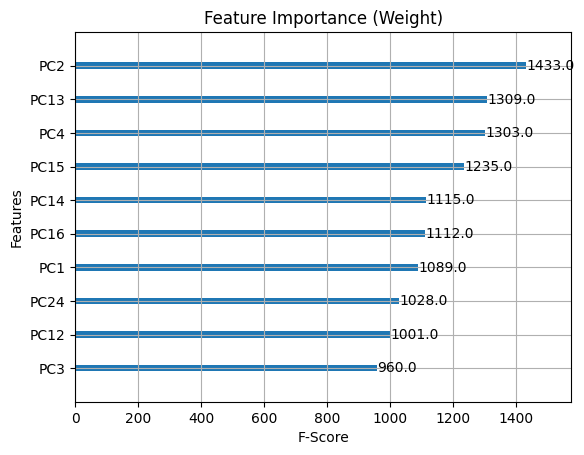

<Figure size 1000x800 with 0 Axes>

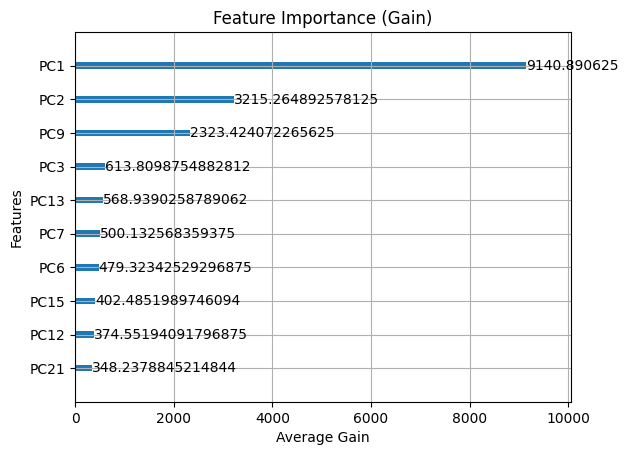

In [84]:
# Use the trained model to plot feature importance
import matplotlib.pyplot as plt
import xgboost as xgb

def plot_feature_importance(model, feature_names):
    feature_names = feature_names.tolist() if isinstance(feature_names, pd.Index) else feature_names
    model.get_booster().feature_names = feature_names
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='weight', max_num_features=10, xlabel='F-Score', )
    plt.title("Feature Importance (Weight)")
    plt.show()
    plt.figure(figsize=(10, 8))
    xgb.plot_importance(model, importance_type='gain', max_num_features=10, xlabel='Average Gain')
    plt.title("Feature Importance (Gain)")
    plt.show()

feature_names = pca_features.index.tolist() if isinstance(pca_features.index, pd.Index) else pca_features.index
# Use the correct feature names for the model
plot_feature_importance(model, feature_names)

Learning Rate: 0.01, MAE: 4.193765164020757
Learning Rate: 0.02, MAE: 3.912171667084216
Learning Rate: 0.03, MAE: 3.836404178136877
Learning Rate: 0.04, MAE: 3.8158521320610044
Learning Rate: 0.05, MAE: 3.8107583378787355
Learning Rate: 0.06, MAE: 3.8092248142576093
Learning Rate: 0.07, MAE: 3.8024167632339023
Learning Rate: 0.08, MAE: 3.804754479554409
Learning Rate: 0.09, MAE: 3.804903878505124
Learning Rate: 0.1, MAE: 3.8064899525861002


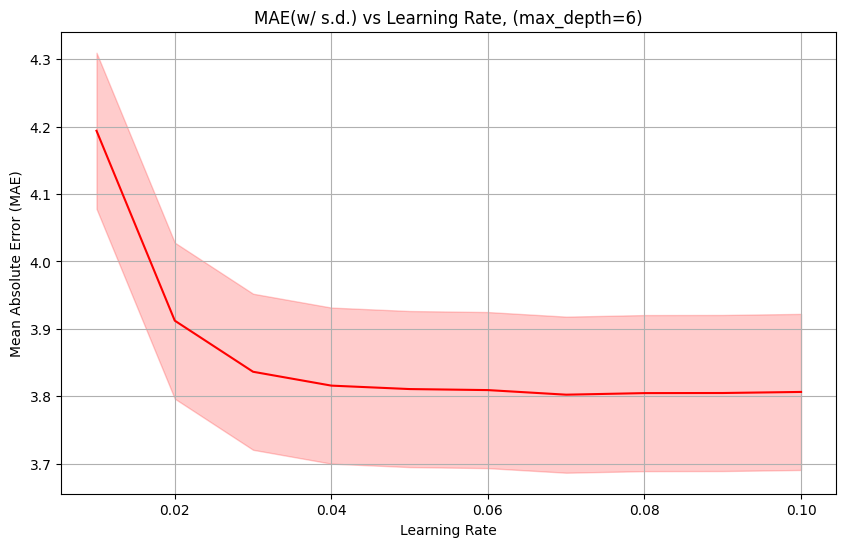

In [85]:
# Use the trained model to plot MAE against various learning rates with area of std deviation as shaded region
learning_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
def plot_mae_vs_learning_rate(X_train_pca, y_train, X_test_pca, y_test, learning_rates):
    mae_values = []
    for lr in learning_rates:
        model = XGBRegressor(learning_rate=lr)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Learning Rate: {lr}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(learning_rates, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(learning_rates, mae_values, color='r')
    plt.xlabel('Learning Rate')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Learning Rate, (max_depth=6)')
    plt.grid(True)
    plt.show()

plot_mae_vs_learning_rate(X_train_pca, y_train, X_test_pca, y_test, learning_rates)

Max Depth: 3, MAE: 4.262522158739673
Max Depth: 4, MAE: 4.224580454832221
Max Depth: 5, MAE: 4.206303046294627
Max Depth: 6, MAE: 4.193765164020757
Max Depth: 7, MAE: 4.188733084759289
Max Depth: 8, MAE: 4.186369175841729
Max Depth: 9, MAE: 4.188852645611535
Max Depth: 10, MAE: 4.192731899235508


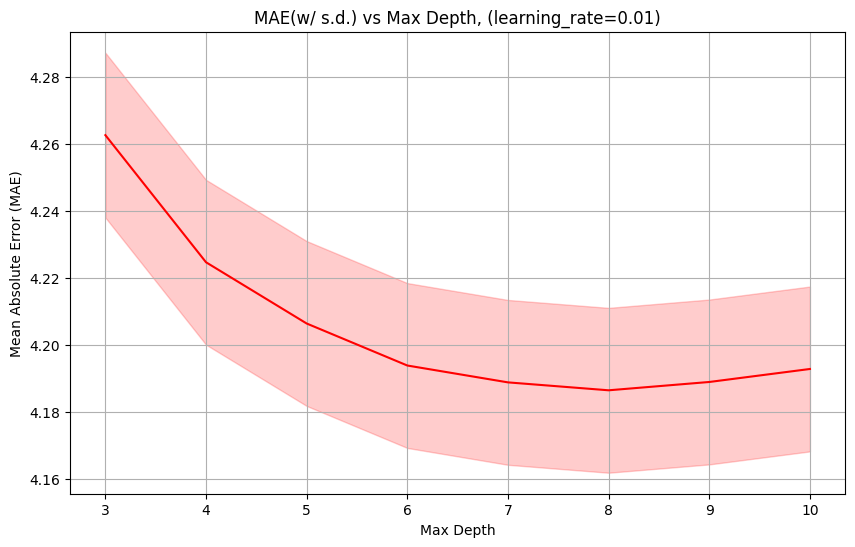

In [86]:
# Use the trained model to plot MAE against various max_depth with area of std deviation as shaded region
max_depths = [3, 4, 5, 6, 7, 8, 9, 10]
def plot_mae_vs_max_depth(X_train_pca, y_train, X_test_pca, y_test, max_depths):
    mae_values = []
    for md in max_depths:
        model = XGBRegressor(max_depth=md, learning_rate=0.01)
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        mae = mean_absolute_error(y_test, y_pred)
        mae_values.append(mae)
        mae_values_std = np.std(mae_values)
        print(f"Max Depth: {md}, MAE: {mae}")

    plt.figure(figsize=(10, 6))
    plt.fill_between(max_depths, np.array(mae_values) - mae_values_std, np.array(mae_values) + mae_values_std, alpha=0.2, color='r')
    plt.plot(max_depths, mae_values, color='r')
    plt.xlabel('Max Depth')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE(w/ s.d.) vs Max Depth, (learning_rate=0.01)')
    plt.grid(True)
    plt.show()

plot_mae_vs_max_depth(X_train_pca, y_train, X_test_pca, y_test, max_depths)

100%|===================| 12164/12193 [02:25<00:00]        

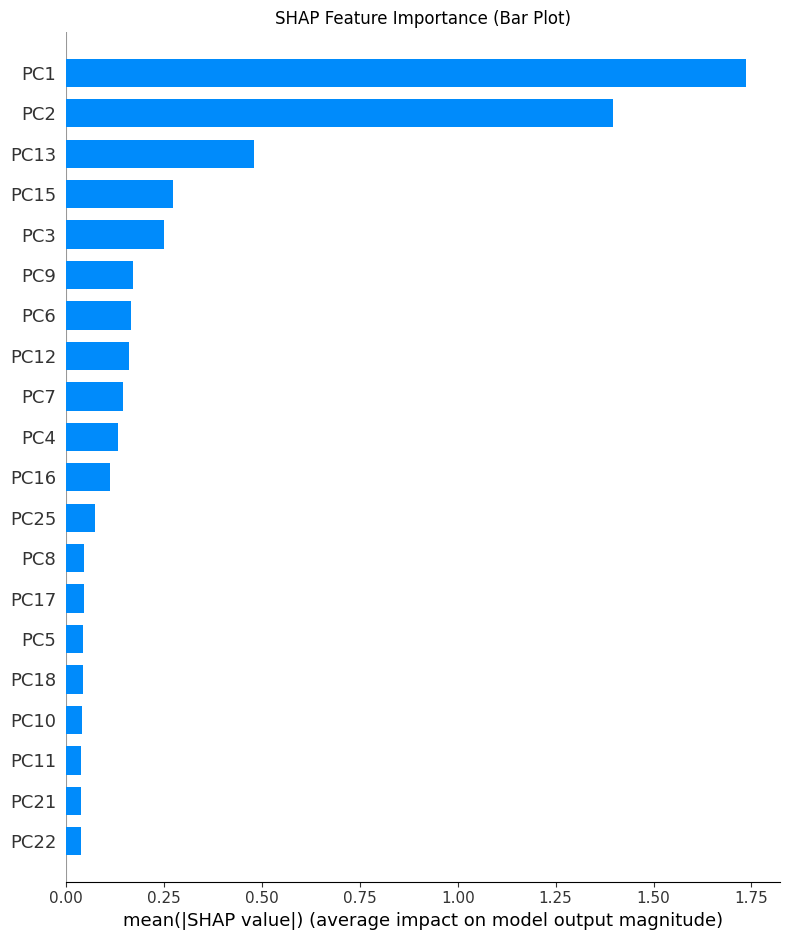

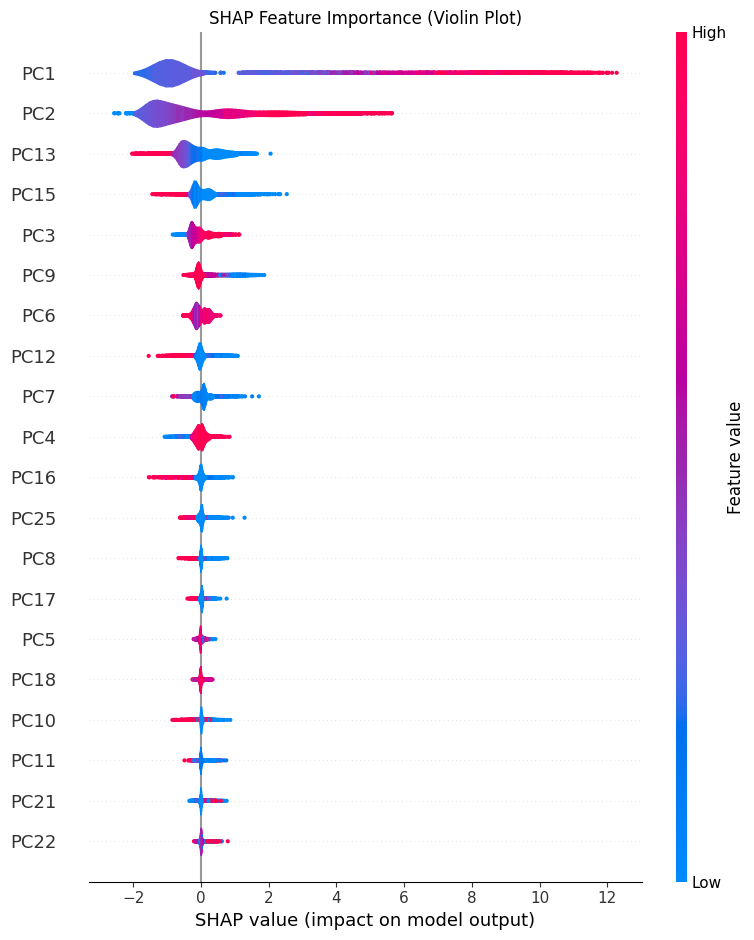

In [87]:
# Plot feature importance using SHAP values
import shap

def plot_shap_feature_importance(model, X_test_pca):
    # Create a SHAP explainer
    explainer = shap.Explainer(model, X_test_pca)
    
    # Calculate SHAP values
    shap_values = explainer(X_test_pca)

    # Use simple PC names
    feature_names = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]

    # Create figure with larger size for better readability
    plt.figure(figsize=(15, 10))
    
    # Summary plot (bar)
    shap.summary_plot(shap_values, X_test_pca, 
                     feature_names=feature_names, 
                     plot_type="bar",
                     show=False)
    plt.title("SHAP Feature Importance (Bar Plot)")
    plt.tight_layout()
    plt.show()

    # Summary plot (violin)
    plt.figure(figsize=(15, 10))
    shap.summary_plot(shap_values, X_test_pca, 
                     feature_names=feature_names, 
                     plot_type="violin",
                     show=False)
    plt.title("SHAP Feature Importance (Violin Plot)")
    plt.tight_layout()
    plt.show()
    
plot_shap_feature_importance(model, X_test_pca)

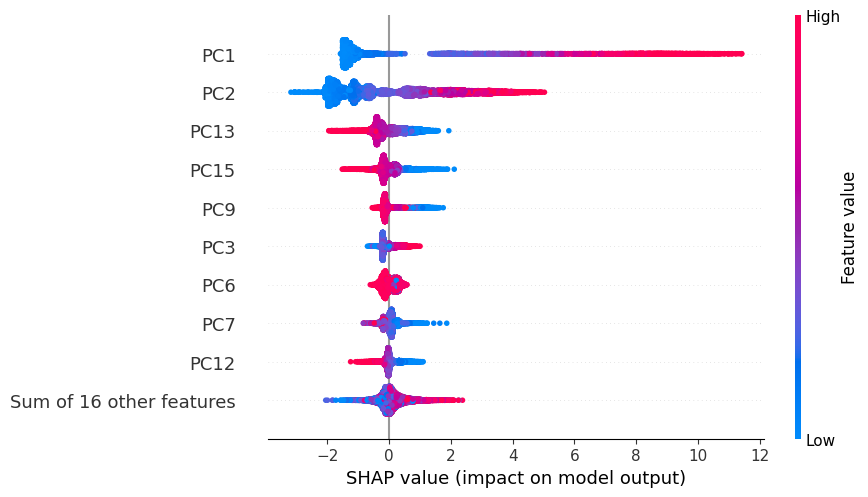

<Figure size 640x480 with 0 Axes>

In [88]:
# Function to use SHAP to explain the machine learning model behavior with SHAP beeswarm plot
import shap

def plot_shap_beeswarm(model, X_test_pca):
    # Convert X_test_pca to DataFrame with PC names as features
    feature_names = [f"PC{i+1}" for i in range(X_test_pca.shape[1])]
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=feature_names)
    
    # Create explainer and calculate SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_pca_df)
    
    # Plot beeswarm
    plt.figure(figsize=(10, 6))
    shap.plots.beeswarm(shap_values)
    plt.tight_layout()

plot_shap_beeswarm(model, X_test_pca)

In [89]:
# Function to use model to predict fantasy points for all weeks in final_df_with_lags, keeping 'player_id' for mapping back to player names later
def predict_fantasy_points(model, pca, final_df_with_lags):
    """
    Predict fantasy points for each player's next game using the trained model.
    
    Args:
        model: Trained XGBoost model
        pca: Trained PCA model
        final_df_with_lags: DataFrame containing player stats with lagged features
        
    Returns:
        DataFrame: Predicted fantasy points with player info
    """
    final_df_with_lags = final_df_with_lags.copy()
    
    # Get features for prediction (exclude first 11 columns and target variable)
    X_ = final_df_with_lags.iloc[:, 11:].drop(columns=['fantasy_points'])
    
    # Scale features using StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_)
    
    # Apply PCA transformation
    X_pca = pca.transform(X_scaled)
    
    # Make predictions using the PCA-transformed data
    predicted_fantasy_points = model.predict(X_pca)
    
    final_df_with_lags['predicted_fantasy_points'] = predicted_fantasy_points

    return final_df_with_lags[['player_id', 'player_name', 'position_group', 'team', 'season', 'week', 'fantasy_points', 'predicted_fantasy_points']]

# Predict fantasy points using the last trained model and PCA
predicted_fantasy_points = predict_fantasy_points(model, pca, final_df_with_lags)
predicted_fantasy_points

,player_id,player_name,position_group,team,season,week,fantasy_points,predicted_fantasy_points
0,00-0007091,M.Hasselbeck,QB,IND,2014,4,-0.20,3.967693
1,00-0007091,M.Hasselbeck,QB,IND,2014,16,7.04,3.396888
2,00-0007091,M.Hasselbeck,QB,IND,2014,17,9.40,9.327344
3,00-0007091,M.Hasselbeck,QB,IND,2015,4,15.38,8.746170
4,00-0007091,M.Hasselbeck,QB,IND,2015,5,16.22,15.456262
...,...,...,...,...,...,...,...,...
60964,00-0039921,T.Benson,RB,ARI,2024,10,8.70,4.992407
60965,00-0039921,T.Benson,RB,ARI,2024,12,1.80,7.172454
60966,00-0039921,T.Benson,RB,ARI,2024,13,2.00,5.266792
60967,00-0039921,T.Benson,RB,ARI,2024,14,1.90,5.167329


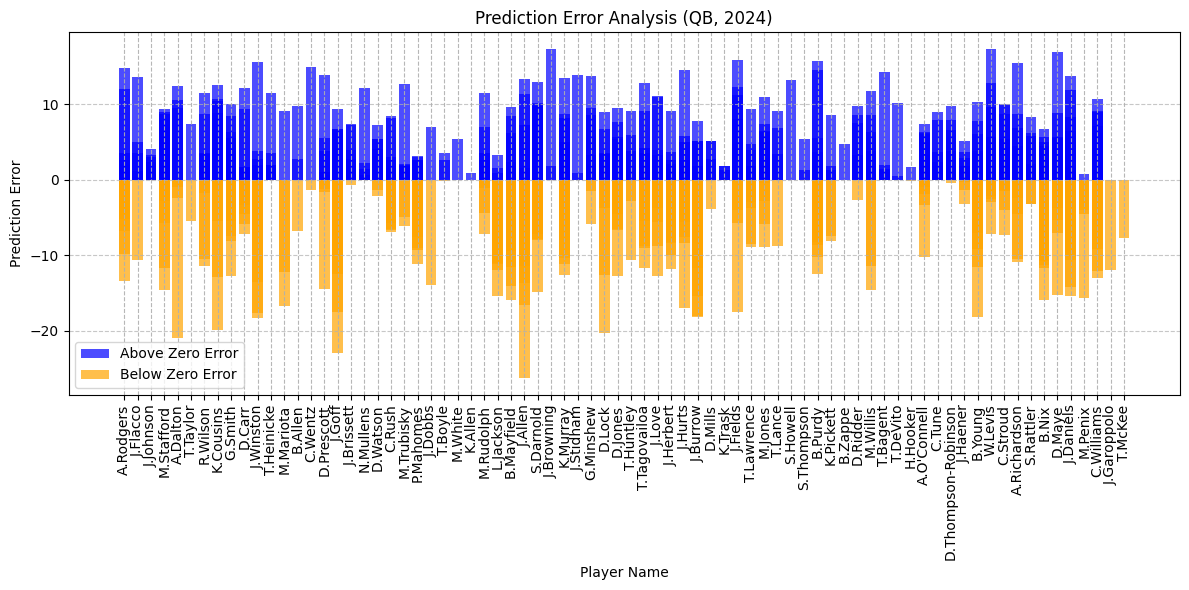

In [90]:
# Function for Prediction error analysis
def analyze_prediction_errors(predicted_fantasy_points):
    predicted_fantasy_points = predicted_fantasy_points.copy()
    # 2024 season only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['season'] == 2024]
    # All QB position_group only
    predicted_fantasy_points = predicted_fantasy_points[predicted_fantasy_points['position_group'] == 'QB']
    predicted_fantasy_points['prediction_error'] = predicted_fantasy_points['predicted_fantasy_points'] - predicted_fantasy_points['fantasy_points']

    # Convert prediction_error to percent_error - not absolute
    predicted_fantasy_points['percent_error'] = (predicted_fantasy_points['prediction_error'] / predicted_fantasy_points['fantasy_points'])

    # Above and below zero errors
    above_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] >= 0]
    below_zero = predicted_fantasy_points[predicted_fantasy_points['prediction_error'] < 0]

    plt.figure(figsize=(12, 6))

    # Plot above 0 error chart with blue color and alpha 0.7
    plt.bar(above_zero['player_name'], above_zero['prediction_error'], color='blue', alpha=0.7, label='Above Zero Error')
    # Plot below 0 error chart with orange color and alpha 0.7
    plt.bar(below_zero['player_name'], below_zero['prediction_error'], color='orange', alpha=0.7, label='Below Zero Error')
    # All vertical grid lines throughout the plot
    plt.grid(axis='x', linestyle='--', alpha=0.9)
    # All horizontal grid lines throughout the plot
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Player Name')
    plt.ylabel('Prediction Error')
    plt.title('Prediction Error Analysis (QB, 2024)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

analyze_prediction_errors(predicted_fantasy_points)


## 2025 Predictions

In [91]:
# Load player game-level stats for 2025 season to identify current rosters
# player_stats_2025 = nfl.load_player_stats(2025)
# player_stats_pandas_2025 = player_stats_2025.to_pandas()
# player_stats_pandas_2025 = player_stats_pandas_2025[player_stats_pandas_2025['season_type'] != 'POST']
# player_stats_pandas_2025

In [92]:
# Create Complete Team Defense Dataframes
# def create_team_defense_df(complete_data_df):
#     # Filter for defensive positions
#     defensive_positions = ['DL', 'LB', 'DB']
#     team_defense_df = complete_data_df[complete_data_df['pos_abb'].isin(defensive_positions)].copy()
    
#     return team_defense_df

# team_defense_df = create_team_defense_df(complete_data_df)
# team_defense_df.columns